In [2]:
! pip install cohere altair > /dev/null

In [3]:
import cohere
import pandas as pd
import numpy as np
import altair as alt

api_key = 'mZyhjGS0iHcDBWzy5kpfVQfJW8Ezeemra6kGUEQi' # Paste your API key here. Remember to not share it publicly
co = cohere.Client(api_key)

In [29]:
# Load the dataset to a dataframe
df = pd.read_csv('/content/drive/MyDrive/ML/reviews_data.csv',skiprows=1,names=['reviews'])

# Take a small sample for illustration purposes
# sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
# df = df_orig.sample(frac=0.12, random_state=30)
# df = df[df.intent.isin(sample_classes)]
# df_orig = df_orig.drop(df.index)
# df.reset_index(drop=True,inplace=True)

# # Remove unnecessary column
# intents = df['intent'] #save for a later need
# df.drop(columns=['intent'], inplace=True)
df.head()

,reviews
0,i updated to the new version on 5/7/19. Now wh...
1,Well it does not interface with my fitness dev...
2,I am not a fan of this app. The app is not res...
3,UPDATE- The app was updated and then it starte...
4,"App frequently signs me out, will not sync dat..."


In [30]:
# Get text embeddings
def get_embeddings(texts,model='embed-english-v2.0'):
  output = co.embed(
                model=model,
                texts=texts)
  return output.embeddings

In [31]:
# Embed the dataset
df['reviews_embeds'] = get_embeddings(df['reviews'].tolist())
df.head()

,reviews,reviews_embeds
0,i updated to the new version on 5/7/19. Now wh...,"[2.3066406, 1.296875, 0.057678223, 0.35888672,..."
1,Well it does not interface with my fitness dev...,"[-0.65722656, 0.3552246, 0.8701172, 0.16442871..."
2,I am not a fan of this app. The app is not res...,"[1.2939453, 0.36645508, 0.048553467, 0.7695312..."
3,UPDATE- The app was updated and then it starte...,"[2.3847656, -0.33129883, -0.98583984, 1.433593..."
4,"App frequently signs me out, will not sync dat...","[1.2646484, 0.18786621, 0.4182129, -0.06378174..."


In [32]:
# Reduce dimensionality using PCA
from sklearn.decomposition import PCA

# Function to return the principal components
def get_pc(arr,n):
  pca = PCA(n_components=n)
  embeds_transform = pca.fit_transform(arr)
  return embeds_transform

In [33]:
# Reduce embeddings to 10 principal components to aid visualization
embeds = np.array(df['reviews_embeds'].tolist())
embeds_pc = get_pc(embeds,10)

In [34]:
# Set sample size to visualize
sample = 9

# Enable Altair to handle larger datasets
alt.data_transformers.enable('default', max_rows=None)
# # Reshape the data for visualization purposes
# source = pd.DataFrame(embeds_pc)[:sample]
# source = pd.concat([source,df['reviews']], axis=1)
# source = source.melt(id_vars=['reviews'])

# Configure the plot
chart = alt.Chart(source).mark_rect().encode(
    x=alt.X('variable:N', title="Embedding"),
    y=alt.Y('reviews:N', title='',axis=alt.Axis(labelLimit=500)),
    color=alt.Color('value:Q', title="Value", scale=alt.Scale(
                range=["#917EF3", "#000000"]))
)

result = chart.configure(background='#ffffff'
        ).properties(
        width=700,
        height=400,
        title='Embeddings with 10 dimensions'
       ).configure_axis(
      labelFontSize=15,
      titleFontSize=12)

# Show the plot
result

alt.Chart(...)

In [35]:
# Function to generate the 2D plot
def generate_chart(df,xcol,ycol,lbl='on',color='basic',title=''):
  chart = alt.Chart(df).mark_circle(size=500).encode(
    x=
    alt.X(xcol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    y=
    alt.Y(ycol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    color= alt.value('#333293') if color == 'basic' else color,
    tooltip=['reviews']
    )

  if lbl == 'on':
    text = chart.mark_text(align='left', baseline='middle',dx=15, size=13,color='black').encode(text='reviews', color= alt.value('black'))
  else:
    text = chart.mark_text(align='left', baseline='middle',dx=10).encode()

  result = (chart + text).configure(background="#FDF7F0"
        ).properties(
        width=800,
        height=500,
        title=title
       ).configure_legend(
  orient='bottom', titleFontSize=18,labelFontSize=18)

  return result

In [36]:
# Reduce embeddings to 2 principal components to aid visualization
embeds_pc2 = get_pc(embeds,2)

# Add the principal components to dataframe
df_pc2 = pd.concat([df, pd.DataFrame(embeds_pc2)], axis=1)

# Plot the 2D embeddings on a chart
df_pc2.columns = df_pc2.columns.astype(str)
generate_chart(df_pc2.iloc[:sample],'0','1',title='2D Embeddings')

alt.LayerChart(...)

In [37]:
from sklearn.cluster import KMeans

# Pick the number of clusters
df_clust = df_pc2.copy()
n_clusters=5

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
classes = kmeans_model.fit_predict(embeds).tolist()
df_clust['cluster'] = (list(map(str,classes)))

# Plot on a chart
df_clust.columns = df_clust.columns.astype(str)
generate_chart(df_clust.iloc[:sample],'0','1',lbl='on',color='cluster',title='Clustering with 2 Clusters')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


alt.LayerChart(...)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

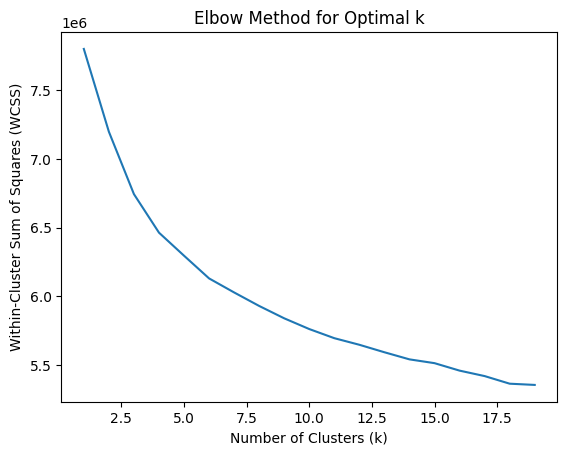

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize an empty list to store the WCSS values
wcss = []

# Specify the range of k values to evaluate
k_values = range(1, 20)  # Adjust the range as per your requirements

# Compute the WCSS for each value of k
for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model.fit(embeds)  # Assuming `embeds` is your input data
    wcss.append(kmeans_model.inertia_)

# Plot the WCSS values
plt.plot(k_values, wcss)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()